# EI Balance

This notebook extends the results from previous analyses (“../notebooks/sfn_2023/sfn_panel_4.ipynb”), incorporating new information about cell type identity.   
Additionally, novel analyses investigating the relationship between excitation:inhibition balance and spiking statistics are included.  
  
Before running this notebook, “...scripts/spike_analysis/compute_spike_stats_EI.py” must be run! This script re-computes population spiking statistics within each cell class.


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# custom imports
import sys
sys.path.append('../../')
from allen_vc.plots import plot_regression_line
from allen_vc.stats import mixedLM
from allen_vc.paths import PATH_EXTERNAL
from scipy.stats import linregress

print("Packages Imported!")

Packages Imported!


## Settings

In [2]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')

## Helper functions

In [3]:
# calc EI balance from DataFrame
def calc_EI(df):
    
    # locate excitatory and inhibitory cell types
    Edf = df.loc[df['cell_type'] == 'excitatory', :]
    Idf = df.loc[df['cell_type'] == 'inhibitory', :]
    
    # calculate E/I balance
    E = Edf['mean_firing_rate'].values[0]
    I = Idf['mean_firing_rate'].values[0]
    
    Ec = Edf['unit_count'].values[0]
    Ic = Idf['unit_count'].values[0]
    
    # append cell-type specific metrics
    variables = ['spike_distance', 'spike_synchrony', 'mean_firing_rate', 'mean_firing_rate', 'mean_fano_factor', 'mean_cv']
    
    E_vars = Edf[variables].reset_index(drop=True)
    I_vars = Idf[variables].reset_index(drop=True)
    
    E_vars.columns = [f'{var}_E' for var in variables]
    I_vars.columns = [f'{var}_I' for var in variables]
    
    
    out_df = pd.concat([pd.DataFrame({'EI_balance': [E/I], 'excitatory_count': [Ec], 'inhibitory_count':[Ic]}),
                       E_vars, I_vars], axis=1)
    
    return out_df

## Load data

In [4]:
# load combined lfp_spike data

# load data for beahvior: stationary
stationary_spikes = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/region_metrics/spontaneous_stationary.csv').assign(behavior='stationary')
stationary_lfp = pd.read_csv(f'{PATH_EXTERNAL}/data/lfp_data/params/psd/spontaneous_stationary/lfp_params.csv')

# modify df_lfp - average over channels for each epoch within each session
stationary_lfp_i = stationary_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(behavior='stationary')

# merge lfp and spike data
nan_i = stationary_lfp_i.merge(stationary_spikes, on=['session', 'epoch_idx', 'behavior'])

# drop nan
behavior_df = nan_i.dropna(subset=['offset'])
print(f'Number of rows after dropping NaNs: {len(nan_i)-len(behavior_df)}')

Number of rows after dropping NaNs: 8


In [5]:
# load data for stim: natural_movie_one_more_repeats

movie_spikes = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/region_metrics/natural_movie_one_more_repeats.csv').assign(presentation='movie')
movie_lfp = pd.read_csv(f'{PATH_EXTERNAL}/data/lfp_data/params/psd/natural_movie_one_more_repeats/lfp_params.csv')

# load data for stim: natural_movie_one_shuffled

shuffled_spikes = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/region_metrics/natural_movie_one_shuffled.csv').assign(presentation='shuffled')
shuffled_lfp = pd.read_csv(f'{PATH_EXTERNAL}/data/lfp_data/params/psd/natural_movie_one_shuffled/lfp_params.csv')

# modify df_lfp - average over channels for each epoch within each session
movie_lfp_i = movie_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='movie')
shuffled_lfp_i = shuffled_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='shuffled')

# concatenate movie and shuffled epoch data
lfp_i = pd.concat([movie_lfp_i, shuffled_lfp_i])
units_i = pd.concat([movie_spikes, shuffled_spikes])

# merge lfp and spike data
nans_i = lfp_i.merge(units_i, on=['session', 'epoch_idx', 'presentation'])

# only consider stationary epochs
nans_i = nans_i[~nans_i['running']]

# drop nan
presentation_df = nans_i.dropna(subset=['offset'])
print(f'Number of rows after dropping NaNs: {len(nans_i)-len(presentation_df)}')

Number of rows after dropping NaNs: 1


In [6]:
# load cell_type specific spike data

# spont
spont = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/by_cell_type/pop_metrics/spontaneous_stationary.csv')

# movie (filter for stationary)
movie = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/by_cell_type/pop_metrics/natural_movie_one_more_repeats.csv')
movie = movie.loc[~movie['running']]

# shuffled (filter for stationary)
shuffled = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/by_cell_type/pop_metrics/natural_movie_one_shuffled.csv')
shuffled = shuffled.loc[~shuffled['running']]

Take a look at cell_type unit counts

In [7]:
spont.groupby(['cell_type'])['unit_count'].sum()

cell_type
excitatory    34066
inhibitory     7294
undefined      4088
Name: unit_count, dtype: int64

In [8]:
movie.groupby(['cell_type'])['unit_count'].sum()

cell_type
excitatory    32234
inhibitory     7078
undefined      3987
Name: unit_count, dtype: int64

In [9]:
shuffled.groupby(['cell_type'])['unit_count'].sum()

cell_type
excitatory    10862
inhibitory     2271
undefined      1506
Name: unit_count, dtype: int64

## Main

In [10]:
# filter for only E or I units
spont_EI = spont.loc[spont['cell_type'] != 'undefined']
movie_EI = movie.loc[movie['cell_type'] != 'undefined']
shuffled_EI = shuffled.loc[shuffled['cell_type'] != 'undefined']

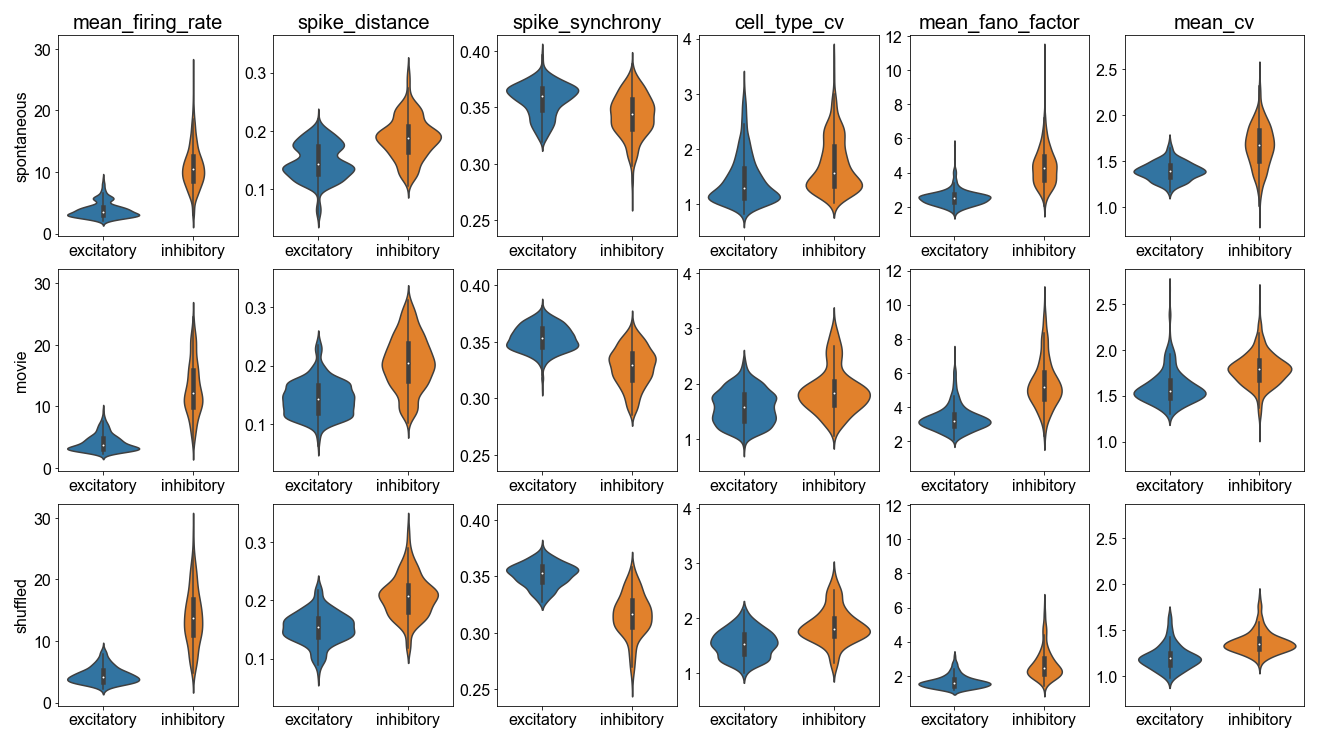

In [11]:
# compare spike metrics between excitatory and inhibitory populations

dfs = {'spontaneous': spont_EI, 'movie': movie_EI, 'shuffled': shuffled_EI}
metrics = ['mean_firing_rate', 'spike_distance', 'spike_synchrony','cell_type_cv', 'mean_fano_factor', 'mean_cv']
fig, ax = plt.subplots(3, len(metrics), figsize=(18, 10), sharey='col')


for i, df_name in enumerate(dfs.keys()):
    for j, metric in enumerate(metrics):

        sns.violinplot(data=dfs[df_name], x='cell_type', y=metric, ax=ax[i, j])
        ax[i, j].set_xlabel('')
        
        if i == 0:
            ax[i,j].set_title(metric)
            
        if j == 0:
            ax[i, j].set_ylabel(df_name)
        else:
            ax[i, j].set_ylabel('')
        

In [12]:
# calc EI balance from DataFrame
def calc_EI(df):
    
    
    # locate excitatory and inhibitory cell types
    Edf = df.loc[df['cell_type'] == 'excitatory', :]
    Idf = df.loc[df['cell_type'] == 'inhibitory', :]
    
    # calculate E/I balance
    E = Edf['mean_firing_rate'].values[0]
    I = Idf['mean_firing_rate'].values[0]
    
    Ec = Edf['unit_count'].values[0]
    Ic = Idf['unit_count'].values[0]
    
    # append cell-type specific metrics
    variables = ['spike_distance', 'spike_synchrony', 'mean_firing_rate', 'mean_fano_factor', 'mean_cv']
    
    E_vars = Edf[variables].reset_index(drop=True)
    I_vars = Idf[variables].reset_index(drop=True)
    
    E_vars.columns = [f'{var}_E' for var in variables]
    I_vars.columns = [f'{var}_I' for var in variables]
    
    
    out_df = pd.concat([pd.DataFrame({'EI_balance': [E/I], 'excitatory_count': [Ec], 'inhibitory_count':[Ic]}).reset_index(drop=True),
                       E_vars, I_vars], axis=1)
    
    return out_df

In [13]:
# calculate E/I balance per epoch (spontaneous)
spont_df_EI = spont_EI.groupby(['session', 'epoch_idx']).apply(calc_EI).reset_index().drop(columns='level_2')
spont_df_EI.head()

,session,epoch_idx,EI_balance,excitatory_count,inhibitory_count,spike_distance_E,spike_synchrony_E,mean_firing_rate_E,mean_fano_factor_E,mean_cv_E,spike_distance_I,spike_synchrony_I,mean_firing_rate_I,mean_fano_factor_I,mean_cv_I
0,766640955,0,0.585096,35,10,0.185607,0.351622,3.833444,1.584733,NaN,0.130167,0.371734,6.551816,3.413041,1.443946
1,766640955,1,0.624046,35,10,0.193162,0.369395,4.360000,2.194652,NaN,0.143448,0.351173,6.986667,4.705916,1.782930
2,766640955,2,0.627663,35,10,0.190445,0.367219,4.209524,NaN,NaN,0.130992,0.357294,6.706667,4.702862,1.935980
3,766640955,3,0.617593,35,10,0.188857,0.365940,4.179048,1.998697,NaN,0.116037,0.358973,6.766667,3.128056,1.573220
4,766640955,4,0.654859,35,10,0.190789,0.368241,4.014286,NaN,NaN,0.142106,0.355550,6.130000,3.486158,1.654175


In [14]:
# calculate E/I balance per epoch (presentation)
movie_df_EI = movie_EI.groupby(['session', 'epoch_idx']).apply(calc_EI).reset_index().drop(columns='level_2')
movie_df_EI['presentation'] = 'movie'

shuffled_df_EI = shuffled_EI.groupby(['session', 'epoch_idx']).apply(calc_EI).reset_index().drop(columns='level_2')
shuffled_df_EI['presentation'] = 'shuffled'

pres_df_EI = pd.concat([movie_df_EI, shuffled_df_EI])
pres_df_EI.head()

,session,epoch_idx,EI_balance,excitatory_count,inhibitory_count,spike_distance_E,spike_synchrony_E,mean_firing_rate_E,mean_fano_factor_E,mean_cv_E,spike_distance_I,spike_synchrony_I,mean_firing_rate_I,mean_fano_factor_I,mean_cv_I,presentation
0,766640955,0,0.635170,35,10,0.176857,0.376910,5.940952,3.613648,NaN,0.143027,0.359524,9.353333,6.174022,1.899651,movie
1,766640955,1,0.556084,35,10,0.175156,0.361787,4.900952,3.064318,NaN,0.138931,0.342734,8.813333,5.924765,1.984713,movie
2,766640955,2,0.506300,35,10,0.171350,0.356770,4.190476,2.817181,NaN,0.120553,0.354997,8.276667,5.269104,2.022566,movie
3,766640955,3,0.540428,35,10,0.175118,0.358190,4.681905,3.260168,1.507451,0.122098,0.357142,8.663333,5.206540,2.043416,movie
4,766640955,4,0.638275,35,10,0.167843,0.368162,4.610476,NaN,NaN,0.123981,0.339534,7.223333,4.965901,1.833747,movie


In [15]:
# combine this data with lfp and spike metrics per epoch

# NOTE: some epochs are cut out in behavior_df compared to df_EI (likely due to invalid LFP)

behavior_df_EI = behavior_df[behavior_df['brain_structure']=='VISp'].merge(spont_df_EI, on=['session', 'epoch_idx'])
presentation_df_EI = presentation_df[presentation_df['brain_structure']=='VISp'].merge(pres_df_EI, on=['session', 'epoch_idx'])

In [16]:
behavior_df_EI.columns

Index(['session', 'epoch_idx', 'offset', 'knee', 'exponent', 'cf_0', 'pw_0',
       'bw_0', 'cf_1', 'pw_1', 'bw_1', 'cf_2', 'pw_2', 'bw_2', 'cf_3', 'pw_3',
       'bw_3', 'error', 'r_squared', 'behavior', 'brain_structure',
       'epoch_times', 'running', 'region_cv', 'spike_distance',
       'spike_synchrony', 'mean_firing_rate', 'mean_fano_factor', 'mean_cv',
       'EI_balance', 'excitatory_count', 'inhibitory_count',
       'spike_distance_E', 'spike_synchrony_E', 'mean_firing_rate_E',
       'mean_fano_factor_E', 'mean_cv_E', 'spike_distance_I',
       'spike_synchrony_I', 'mean_firing_rate_I', 'mean_fano_factor_I',
       'mean_cv_I'],
      dtype='object')

## Plots

In [17]:
# PLOT E spike distance and I spike_distance separately against E:I

In [18]:
# general function for plotting linear regression plot with option to color by session

def linplot(df, x_name, y_name, color_by=None, ax=None):

    pdf = df.dropna(subset=[x_name, y_name])
    
    x = pdf[x_name]
    y = pdf[y_name]

    if color_by is not None:
        
        for subject in pdf[color_by].unique():

            ses_df = pdf[pdf[color_by] == subject]

            x_ses = ses_df[x_name]
            y_ses = ses_df[y_name]

            ax.scatter(x_ses, y_ses, alpha=0.7)
    else:

        ax.scatter(x, y, alpha=0.7)
        
    
    results = linregress(x, y)
    t_lin = np.linspace(min(x), max(x), 100)
    lin = results.slope * t_lin + results.intercept

    ax.plot(t_lin, lin, linewidth=5, color='red')

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.grid(True)

    return results
    

In [19]:
behavior_df_EI['mean_cv'].unique()[:2] # interesting

array([nan, '[nan nan]'], dtype=object)

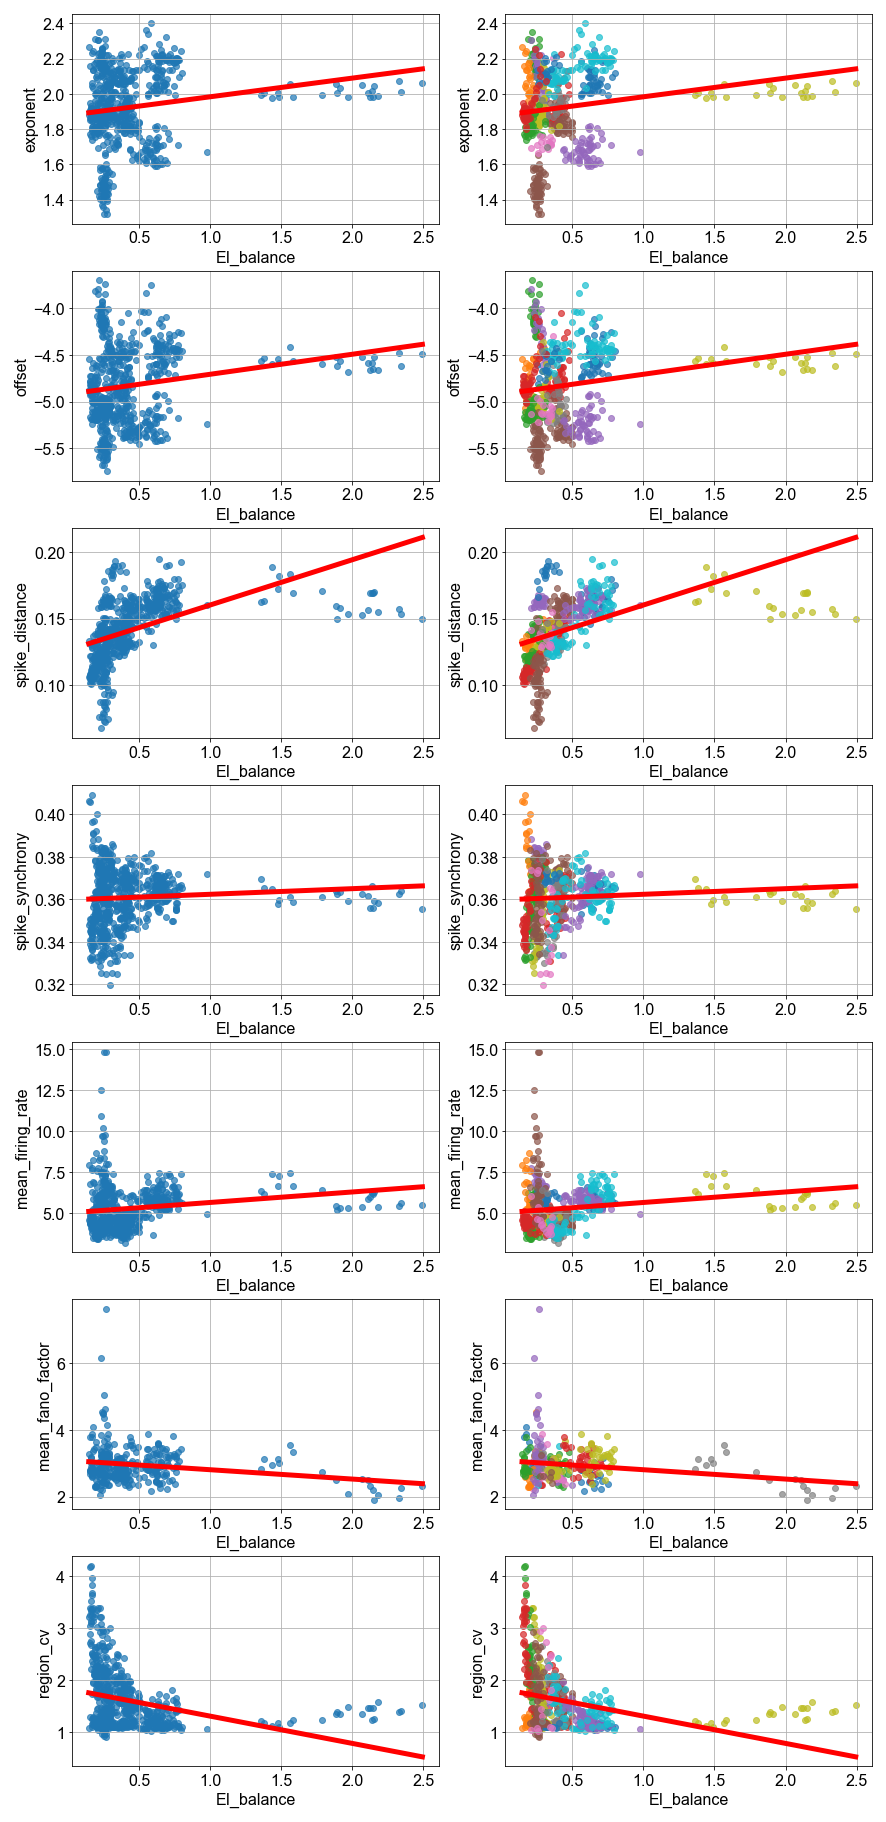

In [20]:
# plot LFP/spike metrics against EI balance all at once (spontaneous)
indep_vars = ['exponent', 'offset', 'spike_distance', 'spike_synchrony', 'mean_firing_rate', 'mean_fano_factor', 'region_cv']

fig, axs = plt.subplots(len(indep_vars), 2, figsize=(12, 25))

for i, var in enumerate(indep_vars):
    
    linplot(behavior_df_EI, 'EI_balance',  var, ax=axs[i,0])
    linplot(behavior_df_EI, 'EI_balance',  var, color_by='session', ax=axs[i,1])

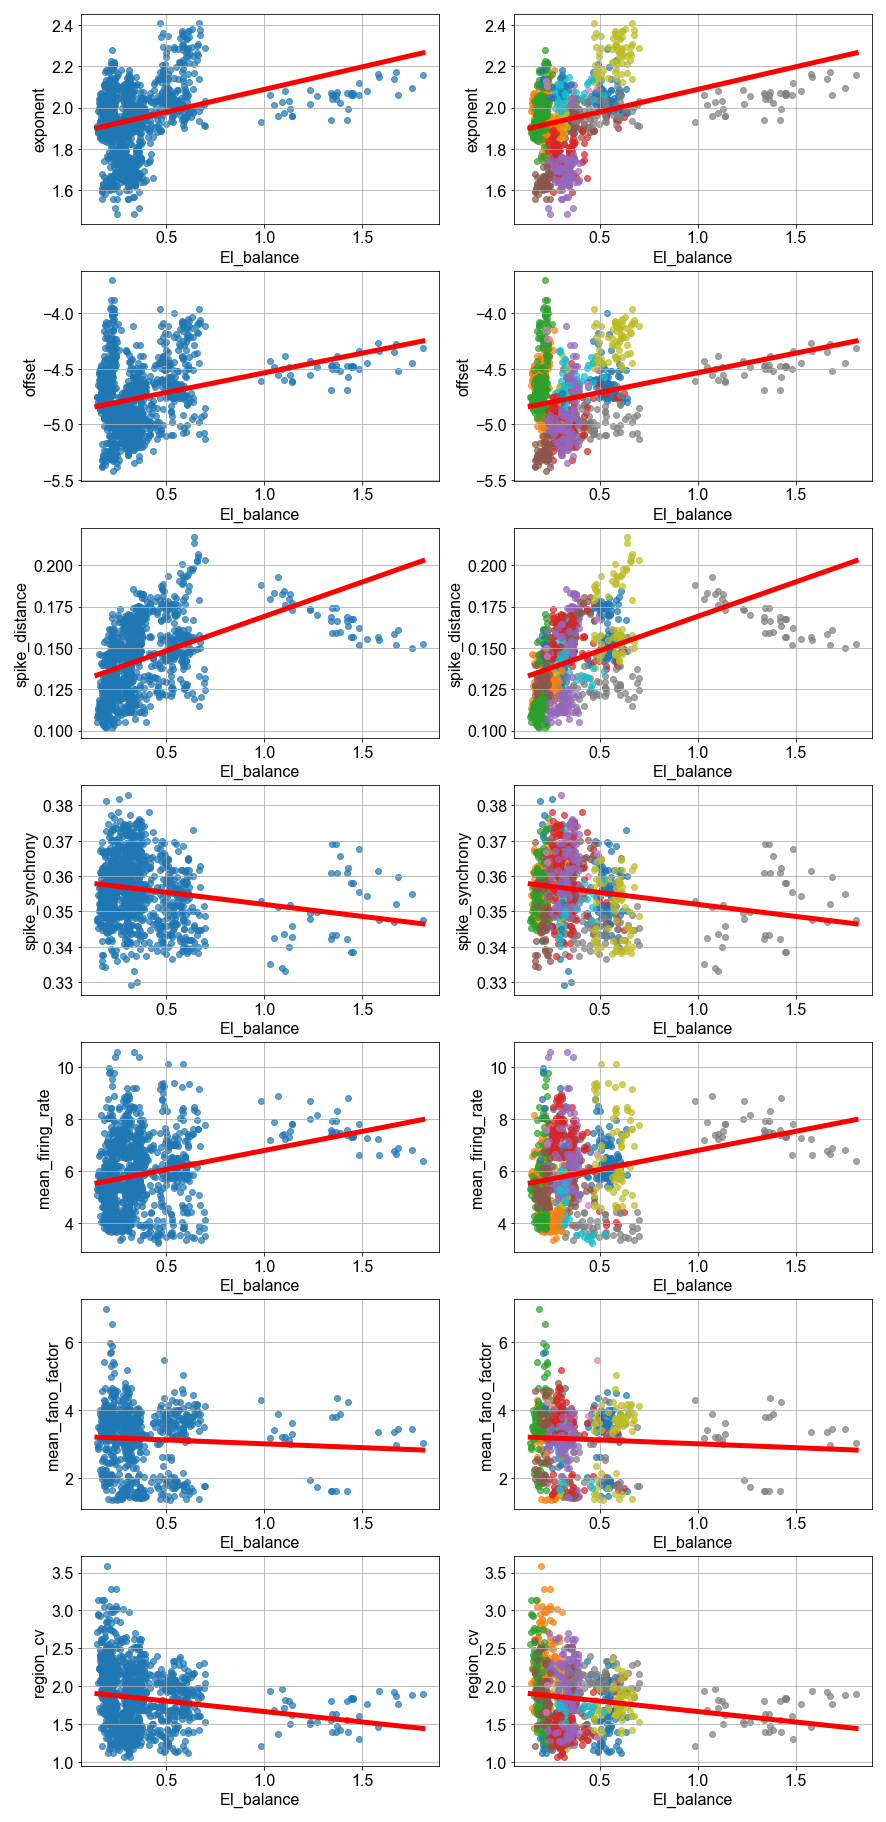

In [21]:
# plot LFP/spike metrics against EI balance all at once (presentation)
indep_vars = ['exponent', 'offset', 'spike_distance', 'spike_synchrony', 'mean_firing_rate', 'mean_fano_factor', 'region_cv']

fig, axs = plt.subplots(len(indep_vars), 2, figsize=(12, 25))

for i, var in enumerate(indep_vars):
    
    linplot(presentation_df_EI, 'EI_balance',  var, ax=axs[i,0])
    linplot(presentation_df_EI, 'EI_balance',  var, color_by='session', ax=axs[i,1])

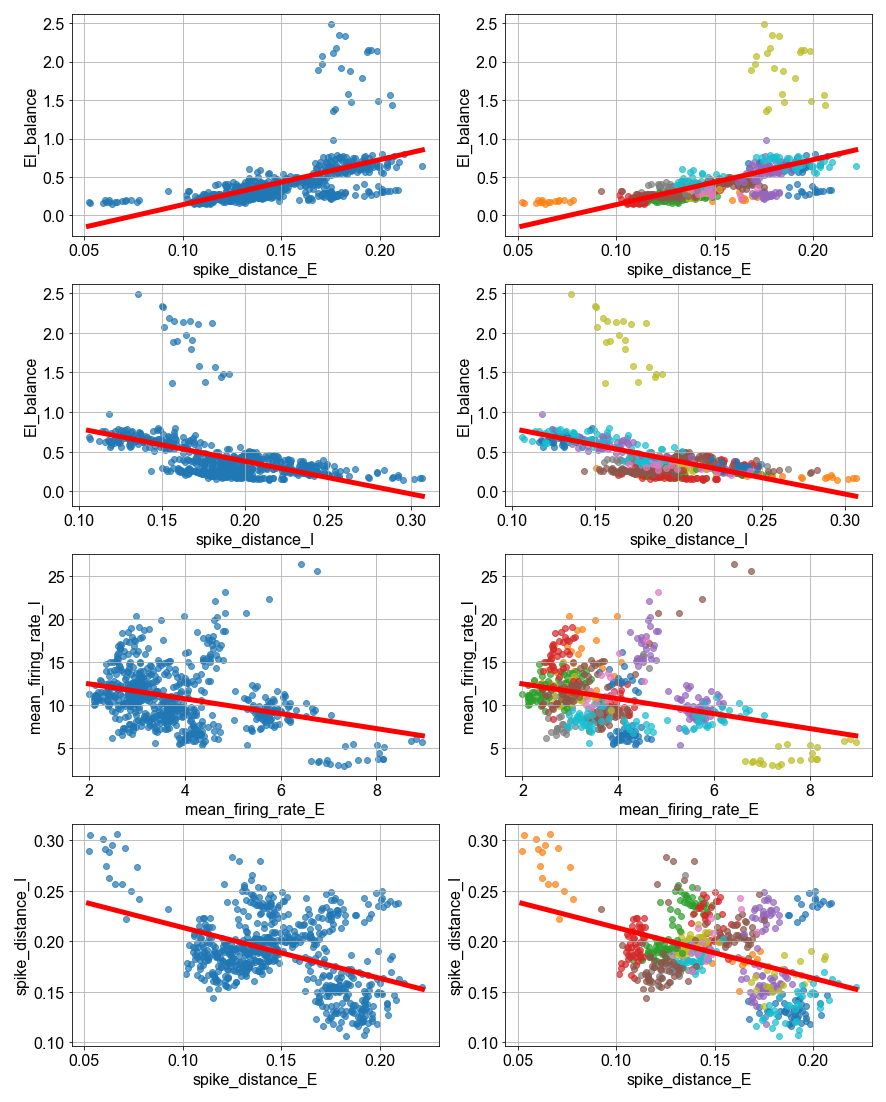

In [22]:
# plot combinations (spontaneous)
plot = [('spike_distance_E', 'EI_balance'), ('spike_distance_I', 'EI_balance'), 
        ('mean_firing_rate_E', 'mean_firing_rate_I'), ('spike_distance_E', 'spike_distance_I')]

fig, axs = plt.subplots(len(plot), 2, figsize=(12, 15))

for i, var in enumerate(plot):
    
    linplot(behavior_df_EI, plot[i][0],   plot[i][1], ax=axs[i,0])
    linplot(behavior_df_EI,  plot[i][0],   plot[i][1], color_by='session', ax=axs[i,1])

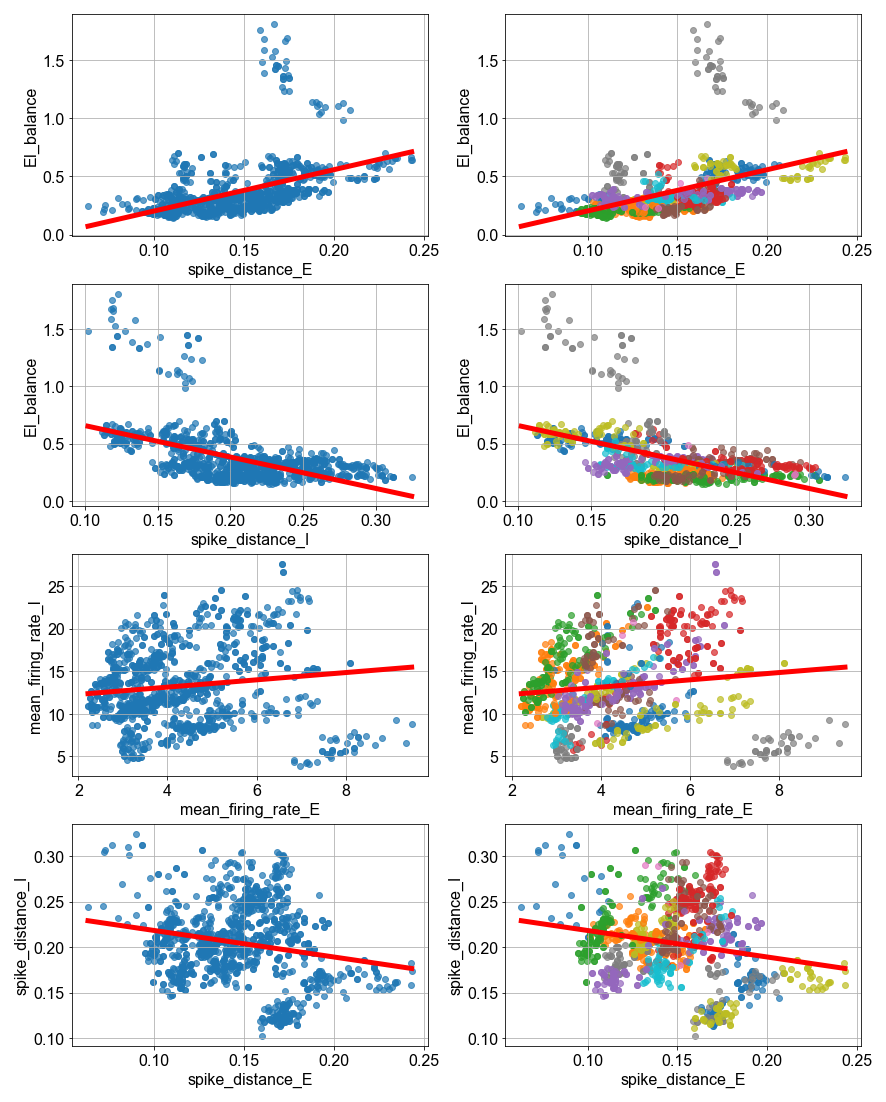

In [23]:
# plot combinations (presentation)
plot = [('spike_distance_E', 'EI_balance'), ('spike_distance_I', 'EI_balance'), 
        ('mean_firing_rate_E', 'mean_firing_rate_I'), ('spike_distance_E', 'spike_distance_I')]

fig, axs = plt.subplots(len(plot), 2, figsize=(12, 15))

for i, var in enumerate(plot):
    
    linplot(presentation_df_EI, plot[i][0],   plot[i][1], ax=axs[i,0])
    linplot(presentation_df_EI,  plot[i][0],   plot[i][1], color_by='session', ax=axs[i,1])

In [24]:
### KEPT BELOW PLOTS JUST IN CASE

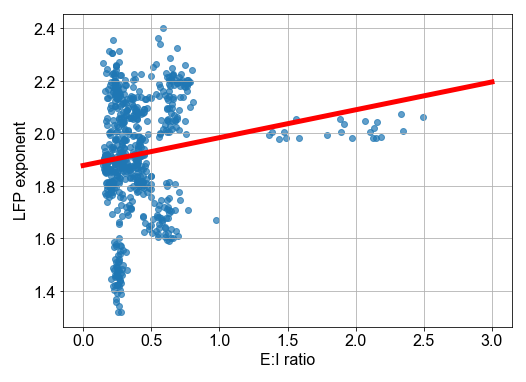

LinregressResult(slope=0.10592141361696639, intercept=1.8775445007553628, rvalue=0.16134962531068972, pvalue=4.233726724738756e-05, stderr=0.02568971071968843, intercept_stderr=0.013837011096684134)


In [25]:
# for spontaneous data

fig = plt.figure(figsize=(7,5))

behavior_df_EI.dropna(subset=['EI_balance', 'exponent'],inplace=True)

x = behavior_df_EI['EI_balance']
y = behavior_df_EI['exponent']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('LFP exponent')
plt.grid(True)
plt.show()

print(results)


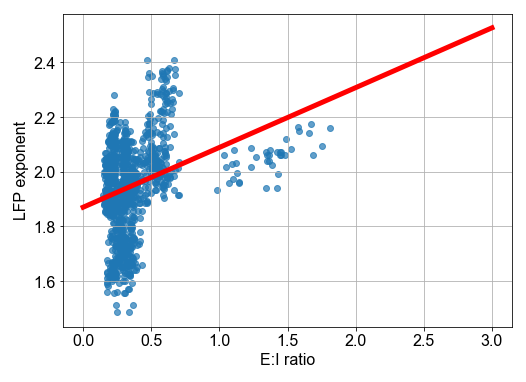

LinregressResult(slope=0.2189187763402287, intercept=1.8693387908083527, rvalue=0.30154621514386215, pvalue=9.104955377896649e-25, stderr=0.020794950184006292, intercept_stderr=0.009059732511618878)


In [26]:
# for movie/shuffled data

fig = plt.figure(figsize=(7,5))

presentation_df_EI.dropna(subset=['EI_balance', 'exponent'],inplace=True)

x = presentation_df_EI['EI_balance']
y = presentation_df_EI['exponent']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('LFP exponent')
plt.grid(True)
plt.show()

print(results)


In [27]:
presentation_df_EI[presentation_df_EI['EI_balance'] > 1.0]

,session,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,spike_synchrony_E,mean_firing_rate_E,mean_fano_factor_E,mean_cv_E,spike_distance_I,spike_synchrony_I,mean_firing_rate_I,mean_fano_factor_I,mean_cv_I,presentation_y
1010,840012044,0,-4.576764,350.880323,1.991127,28.946623,0.376220,8.418590,52.107888,0.368288,...,0.363430,9.348276,3.845593,1.636705,0.151746,0.350147,6.550000,5.753458,1.976274,movie
1011,840012044,7,-4.499764,79.880113,2.040247,24.661602,0.345287,6.426768,51.259016,0.320891,...,0.367479,7.702299,3.435487,NaN,0.118270,0.357234,5.722222,4.743487,1.721650,movie
1012,840012044,7,-4.499764,79.880113,2.040247,24.661602,0.345287,6.426768,51.259016,0.320891,...,0.342501,8.191954,1.542293,1.118438,0.171133,0.331973,6.002778,1.675806,1.213287,shuffled
1013,840012044,7,-4.465835,86.740687,2.061436,17.539033,0.343623,7.296647,53.975016,0.268760,...,0.367479,7.702299,3.435487,NaN,0.118270,0.357234,5.722222,4.743487,1.721650,movie
1014,840012044,7,-4.465835,86.740687,2.061436,17.539033,0.343623,7.296647,53.975016,0.268760,...,0.342501,8.191954,1.542293,1.118438,0.171133,0.331973,6.002778,1.675806,1.213287,shuffled
1015,840012044,8,-4.687673,55.533231,1.940814,18.037141,0.394750,8.424108,36.689041,0.336732,...,0.362211,7.474713,NaN,NaN,0.137064,0.349997,5.586111,5.483653,1.820021,movie
1016,840012044,8,-4.687673,55.533231,1.940814,18.037141,0.394750,8.424108,36.689041,0.336732,...,0.343836,7.979310,1.539472,1.163332,0.177406,0.322760,5.608333,1.877933,1.244010,shuffled
1017,840012044,8,-4.478767,35.416891,2.072627,21.793544,0.391737,7.244097,66.326456,0.320585,...,0.362211,7.474713,NaN,NaN,0.137064,0.349997,5.586111,5.483653,1.820021,movie
1018,840012044,8,-4.478767,35.416891,2.072627,21.793544,0.391737,7.244097,66.326456,0.320585,...,0.343836,7.979310,1.539472,1.163332,0.177406,0.322760,5.608333,1.877933,1.244010,shuffled
1019,840012044,9,-4.471710,65.842933,2.059661,13.904514,0.427699,6.713958,65.168864,0.281289,...,0.358681,7.580460,NaN,NaN,0.122078,0.346310,5.250000,4.342170,1.647673,movie


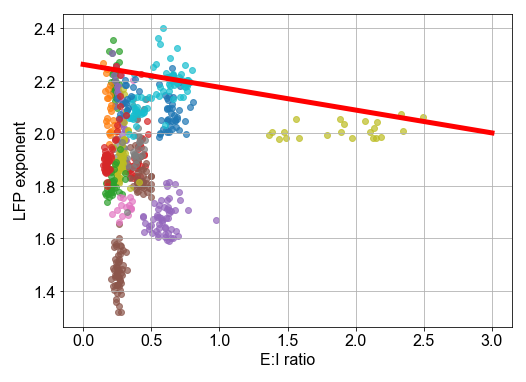

LinregressResult(slope=-0.08683901332830748, intercept=2.2620225373633804, rvalue=-0.125991117256082, pvalue=0.4510125245754981, stderr=0.11395912559476387, intercept_stderr=0.07906556577988844)


In [28]:
# spontaneous: color by subject

fig = plt.figure(figsize=(7,5))

behavior_df_EI.dropna(subset=['EI_balance', 'exponent'],inplace=True)


for subject in behavior_df_EI['session'].unique():
    
    ses_df = behavior_df_EI[behavior_df_EI['session'] == subject]
    
    x = ses_df['EI_balance']
    y = ses_df['exponent']

    plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('LFP exponent')
plt.grid(True)
plt.show()

print(results)


In [29]:
# investigate outlier

behavior_df_EI[behavior_df_EI['EI_balance'] > 1.0]

,session,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,spike_distance_E,spike_synchrony_E,mean_firing_rate_E,mean_fano_factor_E,mean_cv_E,spike_distance_I,spike_synchrony_I,mean_firing_rate_I,mean_fano_factor_I,mean_cv_I
597,840012044,0,-4.567328,424.863217,1.994757,18.296371,0.406787,10.021811,51.277670,0.493894,...,0.176059,0.375499,7.517241,2.532185,1.268010,0.155936,0.363485,5.522222,3.797937,1.505983
598,840012044,1,-4.518248,69.523975,2.047782,48.873764,0.306808,7.414663,65.908821,0.415205,...,0.170783,0.372450,6.941379,2.570477,1.260729,0.151415,0.330989,3.355556,2.678774,1.294821
599,840012044,2,-4.482550,131.194634,2.072344,18.947154,0.457914,4.686864,53.289042,0.342916,...,0.182378,0.368175,7.204598,1.970270,NaN,0.150780,0.341902,3.091667,2.134684,1.328081
600,840012044,3,-4.566071,443.928090,1.983501,16.849105,0.605605,6.481941,51.131657,0.401076,...,0.183925,0.365595,8.158621,2.601500,1.340914,0.172502,0.340051,5.150000,4.661606,1.757112
601,840012044,4,-4.590703,117.228001,2.005363,24.664387,0.325065,9.176147,43.802717,0.521943,...,0.176285,0.371278,7.613793,2.286255,1.269971,0.171748,0.326542,3.611111,3.023577,1.358088
602,840012044,5,-4.489775,31.189051,2.062932,48.687968,0.336953,9.679409,63.006223,0.380934,...,0.175020,0.359806,7.328736,2.138338,1.249584,0.135590,0.331958,2.938889,2.928750,1.449065
603,840012044,6,-4.619213,83.128104,2.008412,19.447670,0.439344,5.679886,53.291063,0.444175,...,0.179137,0.367517,7.400000,2.267655,1.310597,0.149968,0.340933,3.155556,2.620803,NaN
604,840012044,7,-4.535519,541.875483,2.004240,14.104609,0.552354,5.901630,49.223089,0.382750,...,0.176966,0.375976,7.336782,2.643242,NaN,0.175916,0.343114,5.305556,4.383244,1.790516
605,840012044,8,-4.620223,45.543144,2.005546,35.863521,0.365158,8.978061,53.536030,0.389655,...,0.168505,0.373318,6.639080,NaN,NaN,0.159217,0.341493,3.508333,2.504260,1.371047
606,840012044,9,-4.664101,33.036001,1.987357,21.303345,0.295919,8.244721,47.516495,0.352399,...,0.177941,0.364536,7.034483,2.107622,1.255440,0.154545,0.328194,3.222222,2.156008,1.466274


In [30]:
# mean unit counts
behavior_df_EI.groupby('session').mean()

,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,...,spike_distance_E,spike_synchrony_E,mean_firing_rate_E,mean_fano_factor_E,mean_cv_E,spike_distance_I,spike_synchrony_I,mean_firing_rate_I,mean_fano_factor_I,mean_cv_I
session,,,,,,,,,,,,,,,,,,,,,
766640955,21.500000,-4.524636,1257.607818,2.083156,16.706542,0.487510,5.907979,52.306913,0.461150,8.738929,...,0.189027,0.364428,4.166604,2.010330,1.268473,0.131378,0.348760,6.421253,3.855800,1.697296
767871931,5.000000,-4.556528,2234.531553,2.020519,13.648136,0.434287,5.187273,43.656208,0.280974,11.749925,...,0.164698,0.360767,3.405628,2.276063,NaN,0.178942,0.352152,14.589562,5.547289,1.896904
768515987,16.000000,-4.072870,10711.366101,2.194962,10.397541,0.442632,4.988412,44.141714,0.307337,10.427620,...,0.137537,0.363306,3.003718,2.902887,1.461781,0.237689,0.333920,12.888251,3.675838,1.465971
771160300,20.000000,-4.751086,18870.171111,1.918614,25.604235,0.437401,8.253806,52.388439,0.382633,9.550181,...,0.148206,0.355684,3.859184,2.527273,1.410273,0.215873,0.313111,9.812602,4.504764,1.734500
771990200,13.888889,-4.252223,27649.657432,2.111877,20.149893,0.417072,6.928382,50.552331,0.363002,10.219748,...,0.175921,0.377829,4.563081,2.153481,NaN,0.228232,0.373731,17.072840,3.362674,1.242561
774875821,19.000000,-5.276564,219.204114,1.828175,20.656003,0.447799,6.348607,58.180875,0.403752,9.095031,...,0.161906,0.368461,3.736786,2.034191,NaN,0.207612,0.332736,8.790521,4.133295,1.726815
778240327,0.000000,-4.301647,40282.553614,2.200899,13.305932,0.582722,5.016386,68.755449,0.361729,11.076520,...,0.144611,0.361169,3.718687,2.854904,NaN,0.198589,0.359839,10.269444,4.111472,1.503914
778998620,18.000000,-5.022075,1848.888557,1.959493,33.550924,0.391972,9.033699,69.915732,0.374737,9.941625,...,0.127863,0.345532,3.044965,2.341162,1.409247,0.177053,0.343317,8.837838,3.932890,1.613686
779839471,24.500000,-4.982185,4972.728384,1.909812,26.930113,0.383145,8.178695,58.005809,0.344535,9.823415,...,0.138461,0.347322,3.067360,2.669619,1.486525,0.198031,0.339251,11.133176,4.799553,1.741123


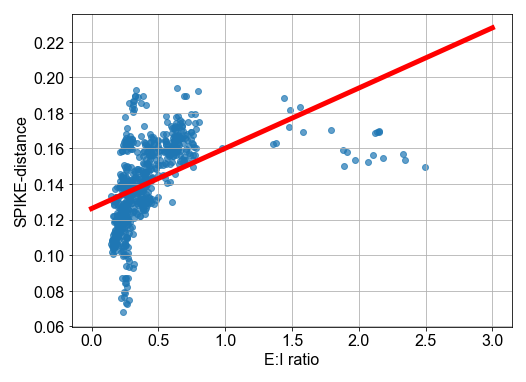

LinregressResult(slope=0.03387799440904414, intercept=0.12620573438725188, rvalue=0.47809962334870665, pvalue=9.481854319676556e-38, stderr=0.002467836543516579, intercept_stderr=0.001329227954726291)


In [31]:
fig = plt.figure(figsize=(7,5))

behavior_df_EI.dropna(subset=['EI_balance', 'spike_distance'],inplace=True)

x = behavior_df_EI['EI_balance']
y = behavior_df_EI['spike_distance']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('SPIKE-distance')
plt.grid(True)
plt.show()

print(results)


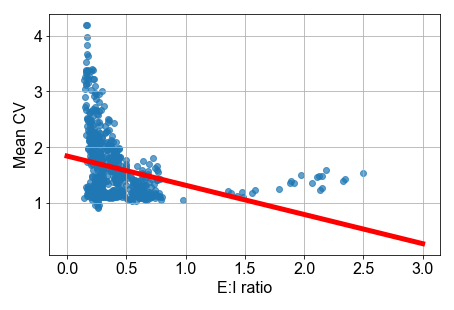

LinregressResult(slope=-0.5245628989089249, intercept=1.8375059195714394, rvalue=-0.29622431474042765, pvalue=2.1776902163086042e-14, stderr=0.06706648116572478, intercept_stderr=0.03612339797172096)


In [32]:

fig = plt.figure()

behavior_df_EI.dropna(subset=['EI_balance', 'region_cv'],inplace=True)

x = behavior_df_EI['EI_balance']
y = behavior_df_EI['region_cv']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('Mean CV')
plt.grid(True)
plt.show()

print(results)


## Mixed LM

In [ ]:
from allen_vc.stats import mixedLM


In [33]:
behavior_df.columns

Index(['session', 'epoch_idx', 'offset', 'knee', 'exponent', 'cf_0', 'pw_0',
       'bw_0', 'cf_1', 'pw_1', 'bw_1', 'cf_2', 'pw_2', 'bw_2', 'cf_3', 'pw_3',
       'bw_3', 'error', 'r_squared', 'behavior', 'brain_structure',
       'epoch_times', 'running', 'region_cv', 'spike_distance',
       'spike_synchrony', 'mean_firing_rate', 'mean_fano_factor', 'mean_cv'],
      dtype='object')

In [34]:
# spontaneous: LFP aperiodic parameters ~ E:I ratio and population spike metrics (across all unit types)

# spontaneous global metrics
df = behavior_df_EI.dropna(subset=['mean_firing_rate', 'EI_balance', 'spike_distance', 'offset', 'exponent'])

covariates = ['mean_firing_rate', 'EI_balance', 'spike_distance']
mixedLM(df, 'offset', covariates, 'session')
results = mixedLM(df, 'exponent', covariates, 'session')

          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  offset  
No. Observations:   638      Method:              REML    
No. Groups:         20       Scale:               0.0211  
Min. group size:    1        Log-Likelihood:      217.4110
Max. group size:    57       Converged:           Yes     
Mean group size:    31.9                                  
----------------------------------------------------------
                 Coef.  Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------
mean_firing_rate  0.021    0.007 2.902 0.004  0.007  0.035
EI_balance        0.226    0.073 3.095 0.002  0.083  0.370
spike_distance    5.443    0.690 7.888 0.000  4.090  6.795
Group Var        32.614   71.839                          

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  exponent
No. Observations:  638      Method:              REML    
No. Groups:        2

In [35]:
# spontaneous: LFP aperiodic parameters ~ population spike metrics within each cell class

# spontaneous cell-type specific metrics
df = behavior_df_EI.dropna(subset=['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I', 'offset', 'exponent'])

covariates = ['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I']
mixedLM(df, 'offset', covariates, 'session')
results = mixedLM(df, 'exponent', covariates, 'session')

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   offset  
No. Observations:    638       Method:               REML    
No. Groups:          20        Scale:                0.0221  
Min. group size:     1         Log-Likelihood:       203.2539
Max. group size:     57        Converged:            Yes     
Mean group size:     31.9                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
spike_distance_E    1.939    0.910  2.132 0.033  0.157  3.722
spike_distance_I   -0.423    0.565 -0.748 0.454 -1.530  0.685
mean_firing_rate_E  0.109    0.019  5.807 0.000  0.072  0.146
mean_firing_rate_I -0.016    0.005 -3.324 0.001 -0.026 -0.007
Group Var          27.005   58.758                           

            Mixed Linear Model Regression Results
Model:               MixedLM   

In [36]:
# movies+shuffled: LFP aperiodic parameters ~ E:I ratio and population spike metrics (across all unit types)

# presentation global metrics
df = presentation_df_EI.dropna(subset=['mean_firing_rate', 'EI_balance', 'spike_distance', 'offset', 'exponent'])

covariates = ['mean_firing_rate', 'EI_balance', 'spike_distance']
mixedLM(df, 'offset', covariates, 'session')
results = mixedLM(df, 'exponent', covariates, 'session')

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  offset  
No. Observations:    1110     Method:              REML    
No. Groups:          20       Scale:               0.0151  
Min. group size:     2        Log-Likelihood:      637.8774
Max. group size:     108      Converged:           Yes     
Mean group size:     55.5                                  
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
mean_firing_rate -0.015    0.006 -2.611 0.009 -0.027 -0.004
EI_balance        0.146    0.060  2.430 0.015  0.028  0.264
spike_distance    1.221    0.458  2.663 0.008  0.322  2.119
Group Var        23.459   60.790                           

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  exponent 
No. Observations:   1110     Method:              REML     
N

In [37]:
# movies+shuffled: LFP aperiodic parameters ~ population spike metrics within each cell class

# presentation cell-type specific metrics
df = presentation_df_EI.dropna(subset=['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I', 'offset', 'exponent'])

covariates = ['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I']
mixedLM(df, 'offset', covariates, 'session')
results = mixedLM(df, 'exponent', covariates, 'session')

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   offset  
No. Observations:    1110      Method:               REML    
No. Groups:          20        Scale:                0.0150  
Min. group size:     2         Log-Likelihood:       638.5816
Max. group size:     108       Converged:            Yes     
Mean group size:     55.5                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
spike_distance_E    0.681    0.414  1.646 0.100 -0.130  1.492
spike_distance_I    0.366    0.258  1.420 0.156 -0.139  0.872
mean_firing_rate_E  0.022    0.011  2.043 0.041  0.001  0.042
mean_firing_rate_I -0.009    0.002 -3.447 0.001 -0.013 -0.004
Group Var          23.501   60.798                           

            Mixed Linear Model Regression Results
Model:              MixedLM   D

In [43]:
# movie-watching only: LFP aperiodic parameters ~ population spike metrics within each cell class

# movies ONLY cell-type specific metrics
mdf = presentation_df[presentation_df['brain_structure']=='VISp'].merge(movie_df_EI, on=['session', 'epoch_idx'])

df = mdf.dropna(subset=['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I', 'offset', 'exponent'])

covariates = ['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I']
mixedLM(df, 'offset', covariates, 'session')
results = mixedLM(df, 'exponent', covariates, 'session')

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   offset  
No. Observations:    756       Method:               REML    
No. Groups:          19        Scale:                0.0139  
Min. group size:     2         Log-Likelihood:       433.4008
Max. group size:     72        Converged:            Yes     
Mean group size:     39.8                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
spike_distance_E    0.690    0.531  1.300 0.194 -0.350  1.731
spike_distance_I    1.414    0.402  3.515 0.000  0.625  2.202
mean_firing_rate_E  0.047    0.014  3.498 0.000  0.021  0.074
mean_firing_rate_I -0.012    0.003 -3.614 0.000 -0.019 -0.006
Group Var          26.145   71.940                           

            Mixed Linear Model Regression Results
Model:               MixedLM   

In [44]:
# shuffled movies only: LFP aperiodic parameters ~ population spike metrics within each cell class

# shuffled ONLY cell-type specific metrics
sdf = presentation_df[presentation_df['brain_structure']=='VISp'].merge(shuffled_df_EI, on=['session', 'epoch_idx'])

df = sdf.dropna(subset=['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I', 'offset', 'exponent'])

covariates = ['spike_distance_E', 'spike_distance_I', 'mean_firing_rate_E', 'mean_firing_rate_I']
mixedLM(df, 'offset', covariates, 'session')
results = mixedLM(df, 'exponent', covariates, 'session')

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   offset  
No. Observations:    354       Method:               REML    
No. Groups:          18        Scale:                0.0121  
Min. group size:     6         Log-Likelihood:       180.6174
Max. group size:     36        Converged:            Yes     
Mean group size:     19.7                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
spike_distance_E    0.544    0.758  0.718 0.473 -0.941  2.029
spike_distance_I   -1.186    0.406 -2.923 0.003 -1.981 -0.391
mean_firing_rate_E  0.013    0.021  0.611 0.541 -0.028  0.053
mean_firing_rate_I  0.001    0.004  0.254 0.800 -0.008  0.010
Group Var          21.896   68.637                           

            Mixed Linear Model Regression Results
Model:               MixedLM   

In [39]:
behavior_df_EI['exponent'].values

array([2.01608908, 2.12705936, 2.09750831, 2.05099883, 2.24922091,
       2.04545661, 2.0952973 , 2.13791079, 2.06060239, 2.05076803,
       2.05545861, 2.05534126, 2.09313894, 2.22106163, 2.08694671,
       1.99627551, 2.01256873, 2.07823804, 2.19138765, 2.11904776,
       2.09842597, 2.01778058, 2.04536962, 2.00439588, 2.11102925,
       2.06951279, 2.04879095, 2.00122269, 2.00306904, 2.18900142,
       2.02299033, 2.04658189, 2.02782277, 2.01430658, 1.99885015,
       2.14474241, 2.14067093, 2.19834411, 2.18060032, 2.13512368,
       2.09431442, 2.19411145, 1.98590543, 2.04550616, 2.00604376,
       2.06100867, 2.00491657, 2.03250726, 2.04963502, 1.99527133,
       2.00966031, 1.95756688, 2.04343122, 2.0431017 , 2.02256841,
       2.35341862, 2.31144547, 2.19434134, 2.30391019, 2.23067472,
       2.2263714 , 2.23926674, 2.19938346, 2.17239646, 2.27286067,
       2.25796984, 2.22924901, 2.1745576 , 2.1839155 , 2.17118678,
       2.14476522, 2.3123024 , 2.19903745, 2.16453006, 2.12986

(array([ 64.,  73., 104.,  47., 147., 250., 254.,  88.,  14.,  69.]),
 array([1.60711427, 1.67402909, 1.74094391, 1.80785872, 1.87477354,
        1.94168836, 2.00860318, 2.07551799, 2.14243281, 2.20934763,
        2.27626245]),
 <BarContainer object of 10 artists>)

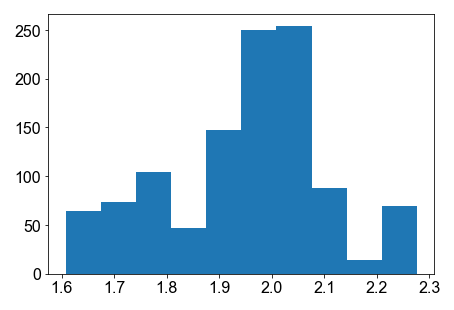

In [40]:
plt.hist(results.fittedvalues)

(array([ 14.,  30.,  31.,  45., 105., 125., 112., 108.,  59.,   9.]),
 array([1.31879125, 1.42703066, 1.53527007, 1.64350948, 1.7517489 ,
        1.85998831, 1.96822772, 2.07646713, 2.18470654, 2.29294596,
        2.40118537]),
 <BarContainer object of 10 artists>)

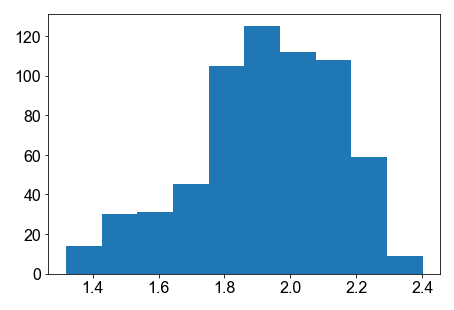

In [41]:
plt.hist(behavior_df_EI['exponent'])